In [1]:
import numpy as np
import sklearn.preprocessing as prep
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
mnist = input_data.read_data_sets("/media/tao/文档/学习/电子书/tensorflow/TensorFlow实战Google深度学习框架/1.0.0/Chapter05/datasets/MNIST_data", one_hot=False)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /media/tao/文档/学习/电子书/tensorflow/TensorFlow实战Google深度学习框架/1.0.0/Chapter05/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting /media/tao/文档/学习/电子书/tensorflow/TensorFlow实战Google深度学习框架/1.0.0/Chapter05/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /media/tao/文档/学习/电子书/tensorflow/TensorFlow实战Google深度学习框架/1.0.0/Chapter05/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /media/tao/文档/学习/电子书/tensorflow/TensorFlow实战Google深度学习框架/1.0.0/Chapter05/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


In [17]:
# Xavier Initializer
def xavier_init(fan_in, fan_out, constant=1):
    low = - constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = - low
    return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)

scaler = prep.StandardScaler().fit(mnist.train.images)
X_train = mnist.train.images - scaler.mean_
# X_test = scaler.transform(mnist.test.images)

def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index:(start_index + batch_size)]

In [18]:
n_samples = int(mnist.train.num_examples)
training_epochs = 80
batch_size = 256
display_step = 2
noise_scale=0.01
learning_rate_base = 0.15
learning_rate_decay = 0.99
regularzation_rate = 0.0002

In [26]:
class DenoiseAutoEncoder:
    def __init__(self, n_input, n_hidden, 
                 transfer_function=tf.nn.relu,
                 scale=noise_scale,
                 learning_rate=learning_rate_base,
                 learning_rate_decay=learning_rate_decay
                ):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function
        self.scale = tf.placeholder(tf.float32)
        self.training_scale = scale
        self.weights = self._initialize_weights()
        
        self.x = tf.placeholder(tf.float32, (None, self.n_input))
        self.hidden = self.transfer(
                        tf.add(
                            tf.matmul(self.x + scale * tf.random_normal((n_input,)), 
                                        self.weights["w1"]),
                            self.weights["b1"]))
        self.reconstruction = tf.add(
                                    tf.matmul(self.hidden,
                                                self.weights["w2"]),
                                    self.weights["b2"])
        
        # 损失函数与正则化
        self.cost = 0.5 * tf.reduce_mean(tf.pow(tf.subtract(self.x, self.reconstruction), 2.0))
        self.regularizer = tf.contrib.layers.l2_regularizer(regularzation_rate)
        self.regularaztion = self.regularizer(self.weights["w1"]) + self.regularizer(self.weights["w2"])
        total_loss = self.regularaztion + self.cost
        
        # 学习速率衰减
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(learning_rate, 
                                                   global_step, 
                                                   mnist.train.num_examples / batch_size, 
                                                   learning_rate_decay, 
                                                   staircase=True)
        
        
        self.optimizer_op = tf.train.AdadeltaOptimizer(learning_rate=learning_rate).minimize(total_loss, 
                                                                                             global_step=global_step)
        
        
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)
    
    def _initialize_weights(self):
        all_weights = dict()
        
        all_weights["w1"] = tf.Variable(xavier_init(self.n_input, self.n_hidden))
        all_weights["b1"] = tf.Variable(tf.zeros([self.n_hidden]), dtype=tf.float32)
        all_weights["w2"] = tf.Variable(tf.zeros([self.n_hidden, self.n_input]), dtype=tf.float32)
        all_weights["b2"] = tf.Variable(tf.zeros([self.n_input]), dtype=tf.float32)
        
        return all_weights
    
    def partial_fit(self, X):
        cost, opt = self.sess.run([self.cost, self.optimizer_op], feed_dict={self.x:X, self.scale: self.training_scale})
        return cost
    
    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict={self.x:X, self.scale:self.training_scale})
    
    def transform(self, X):
        return self.sess.run(self.hidden, feed_dict={self.x: X, self.scale: self.training_scale})
    
    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict={self.x:X, self.scale:self.training_scale})
    
    def generate(self, hidden=None):
        if hidden is None:
            hidden = np.random.normal(size=self.weights["b1"])
        return self.sess.run(self.reconstruction, feed_dict={self.hidden: hidden})
    
    def getWeights(self):
        return self.sess.run(self.weights['w1'])
    
    def getBias(self):
        return self.sess.run(self.weights["b1"])
    
autoencoder = DenoiseAutoEncoder(n_input=784, n_hidden=14*14)

In [27]:
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(n_samples / batch_size)
    for i in range(total_batch):
        batch_xs = get_random_block_from_data(X_train, batch_size)
        cost = autoencoder.partial_fit(batch_xs)
        avg_cost += cost / n_samples * batch_size
    
    if epoch % display_step == 0:
        print("Epoch:", "%04d" % (epoch + 1), "cost=", "{:.9f}".format(avg_cost))

Epoch: 0001 cost= 0.033183153


KeyboardInterrupt: 

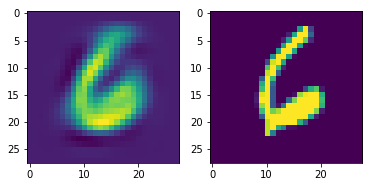

In [25]:
i = 3
a = autoencoder.reconstruct(X_train[i].reshape((-1,784)))
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow((a+scaler.mean_).reshape((28,28)))
ax = fig.add_subplot(122)
ax.imshow((scaler.mean_+X_train[i]).reshape((28,28)))
plt.show()